In [285]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_curve


# plot precision-recall
def plot_precision_recall(list_of_precision, list_of_recall, x_label):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.grid(True)
    ax.legend(loc='right')
    ax.set_xlabel('Model Type')
    ax.set_ylim(0.7, 1)
    plt.title('Precision-Recall')
    x = range(1, len(list_of_precision) + 1)
    ax.plot(x, list_of_precision, '*-', label='Precision')
    ax.plot(x, list_of_recall, '<-', label='Recall')    
    plt.xticks(x, x_label, rotation='vertical')
    ax.legend()
    plt.show()


In [286]:
# load result from csv as numpy
result_file = "/Users/lucindazhao/strava/ml-local/result/cnn_noWeight_lr=0.001_20200218-224657.h5.csv"
result = np.genfromtxt(result_file, delimiter=',', skip_header=1)


In [287]:
len(result)

464452

In [223]:
# # for spark xgb
# # for each row it's [label, is_validation, score]
# v_list = result[(result[:,1] > 0.5)][:, [0,2]]


In [288]:
# for local result
v_list = result

In [289]:

y_true = v_list[:, 0]
y_scores = v_list[:, 1]

In [290]:
num_p = np.count_nonzero(y_true > 0.5, axis=0)
num_n = np.count_nonzero(y_true < 0.5, axis=0)
mislabel_percent = num_p / (num_n + num_p) * 100

# Here is the setting. We have num_p eBike and num_n bike but they are all labelled as 'bike', We'd like to plot
# precision-recall curve based off the model

print("Number of Real eBike Rides:" + str(num_p))
print("Number of Real Bike Rides:" + str(num_n))
print("Percent of Mislabels: %" + str(mislabel_percent))

Number of Real eBike Rides:44888
Number of Real Bike Rides:419564
Percent of Mislabels: %9.664723157613704


In [291]:
pre, rec, thre = precision_recall_curve(y_true, y_scores)

print(len(thre))
print(len(pre))
print(len(rec))

myLength = len(thre)

1001
1002
1002


In [292]:
precision = pre[1:myLength]
recall = rec[1:myLength]
thresholds = thre[0:myLength - 1]

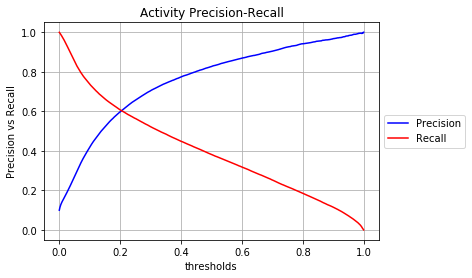

In [293]:
plt.plot(
    thresholds, precision, 'b',
    label='Precision')
plt.plot(
    thresholds, recall, 'r',
    label='Recall')
plt.xlabel('thresholds')
plt.grid(True)
plt.ylabel('Precision vs Recall')
plt.title('Activity Precision-Recall')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend(loc='upper right')
plt.show()

In [294]:
# calculating X if targeting 1% positive samples
X = num_p * 99 / num_n
print(X)

10.591738090017255


In [295]:
# Calculate scaled precision-recall, here are the formulas

# precision = tp / (tp + fp)
# recall = tp / (tp + fn) = tp / num_p
# tp = recall * num_p
# fp = tp / precision - tp

# now assuming we scale negative labels by X times
# tp_new = tp
# fp_new = fp * X = (tp/precision - tp) * X
# precision_new = tp_new / (tp_new + fp_new)
# recall_new = tp_new / num_p = recall

In [296]:
# binary search
def search(x, target):
    l = 0
    r = len(x)
    while l < r:
        m = (l + r) // 2
        if x[m] >= target:
            r = m
        else:
            l = m + 1
    return l

In [297]:
# idx = search(thresholds, 0.999)
# L = len(precision)
# pre = precision[idx:-1]
# re = recall[idx:-1]
# thre = thresholds[idx:-1]

In [298]:
tp = recall * num_p
fp_new = (np.divide(tp, precision) - tp) * X
precision_new = np.divide(tp, tp + fp_new)


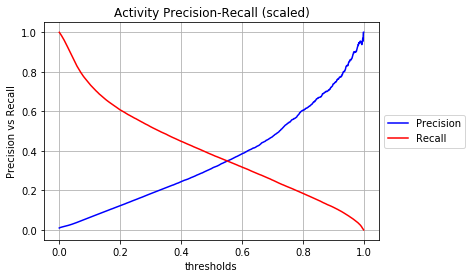

In [299]:
plt.plot(
    thresholds, precision_new, 'b',
    label='Precision')
plt.plot(
    thresholds, recall, 'r',
    label='Recall')
plt.xlabel('thresholds')
plt.grid(True)
plt.ylabel('Precision vs Recall')
plt.title('Activity Precision-Recall (scaled)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend(loc='upper right')
plt.show()

In [300]:
# print interesting points
pThrs = [0.8, 0.9]
for pThr in pThrs:
    pIdx = search(precision_new, pThr)
    print("{}% precision --> {}% recall. Threshold={}".format(pThr*100, recall[pIdx]*100, thresholds[pIdx]))

80.0% precision --> 8.730618428087684% recall. Threshold=0.933
90.0% precision --> 4.729549099982178% recall. Threshold=0.972


# Compare score distribution

In [301]:
p_scores = v_list[(v_list[:, 0] > 0.5), 1]

n_scores = v_list[(v_list[:, 0] < 0.5), 1]



In [302]:
p_histogram = np.histogram(p_scores,bins=10) 
n_histogram = np.histogram(n_scores, bins=10) 

In [303]:
p_histogram

(array([11706,  5885,  3854,  3288,  2996,  2874,  2952,  2996,  3148,
         5189]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [304]:
# import ast
# def toNumpy(xx):
#     x = sorted(xx)
#     buckets = np.array([e[0] for e in x])
#     freq = np.array([e[1] for e in x])
#     c = sum(freq)
#     freq = freq / c * 100
#     return (buckets, freq, c)

# list1 = toNumpy(ast.literal_eval(negativeHis[0]['histo']))
# list2 = toNumpy(ast.literal_eval(positiveHis[0]['histo']))
# list3 = toNumpy(ast.literal_eval(mockAppHis[0]['histo']))

In [305]:
list_p = []
p_freq = p_histogram[0] / sum(p_histogram[0]) * 100
list_p.append(p_histogram[1][1:])
list_p.append(p_freq)



In [306]:
list_n = []
n_freq = n_histogram[0] / sum(n_histogram[0]) * 100
list_n.append(n_histogram[1][1:])
list_n.append(n_freq)

In [307]:
import matplotlib.pyplot as plt
import math
import numpy as np

def plot_histogram(p, axs, list1, my_title='Score Distribution (Positive Label)', color='r'):
    # list1 is a tuple where list1[0] is numpy array of bucket and list1[1] is numpy array of frequency
    x_axis = np.array(list1[0])
    bar_width = 1.0 / len(list1[0]) * 0.6
    opacity = 1
    rects1 = axs.bar(list1[0], list1[1], bar_width,
                     alpha=opacity,
                     color=color,
                     label="Distribution")
    p.title(my_title)
    p.xticks(rotation=90)
    p.xticks(x_axis, list(map(lambda v: '{:6.2f}'.format(v), list1[0])))
    axs.ylabel("Percent")
    axs.xlabel("Score")
    # axs.xlabel("Error In %")
    axs.legend()
    

def plot_overall_histogram(p, axs, list_n, list_p, my_title='Score Distribution'):
    # list1 is a tuple where list1[0] is numpy array of bucket and list1[1] is numpy array of frequency
    x_axis = np.array(list_n[0])
    bar_width = 1.0 / len(list_n[0]) * 0.6
    opacity = 0.4
    rects1 = axs.bar(list_n[0], list_n[1], bar_width,
                     alpha=opacity,
                     color='b',
                     label="Distribution (Negative Label)")
    rects2 = axs.bar(list_p[0], list_p[1], bar_width,
                     alpha=1,
                     color='r',
                     label="Distribution (Positive Label)")
    p.title(my_title)
    p.xticks(rotation=90)
    p.xticks(x_axis, list(map(lambda v: '{:6.2f}'.format(v), list_n[0])))
    axs.ylabel("Sample Count")
    axs.xlabel("Score")
    # axs.xlabel("Error In %")
    axs.legend()

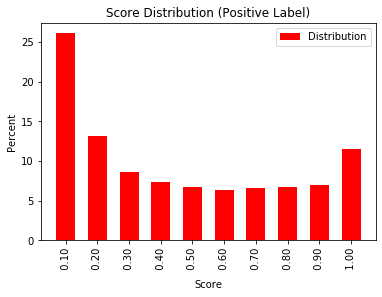

In [308]:
plot_histogram(plt, plt, list_p, my_title='Score Distribution (Positive Label)', color='r')
plt.show()

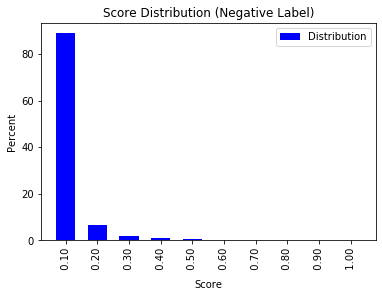

In [309]:
plot_histogram(plt, plt, list_n, my_title='Score Distribution (Negative Label)', color='b')
plt.show()

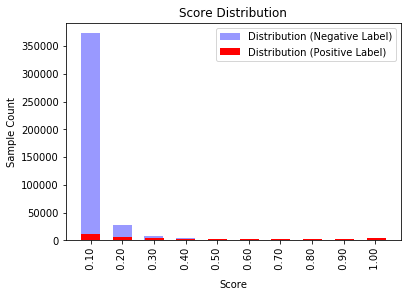

In [310]:
list_p = []
list_p.append(p_histogram[1][1:])
list_p.append(p_histogram[0][:])

list_n = []
list_n.append(n_histogram[1][1:])
list_n.append(n_histogram[0][:])

plot_overall_histogram(plt, plt, list_n, list_p)
plt.show()


In [311]:
y_true[[1,2]]

array([0., 0.])

In [312]:
y_true.shape

(464452,)

# Plot accuracy curve

In [313]:
# accuracy is the average of accuracy|negative label and accuracy|positive label

# precision = tp / (tp + fp)
# recall = tp / (tp + fn) = tp / num_p


tp = recall * num_p
fn = num_p - tp
fp = tp *(1/ precision - 1)
tn = num_n - fp

accuracy_p = recall
accuracy_n = tn / num_n
accuracy = (accuracy_p + accuracy_n) / 2


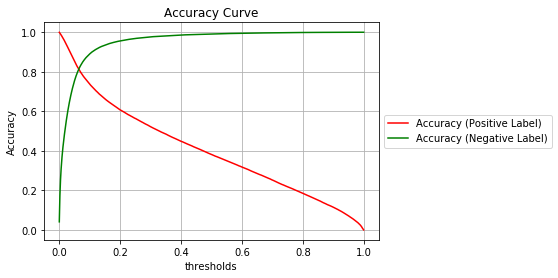

In [314]:
# plt.plot(
#     thresholds, accuracy, 'b',
#     label='Accuracy')
plt.plot(
    thresholds, accuracy_p, 'r',
    label='Accuracy (Positive Label)')
plt.plot(
    thresholds, accuracy_n, 'g',
    label='Accuracy (Negative Label)')
plt.xlabel('thresholds')
plt.grid(True)
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend(loc='upper right')
plt.show()

In [316]:
# print interesting perccentiles for accuracy_p 
pThrs = [0.99, 0.999]
for pThr in pThrs:
    pIdx = search(accuracy_n, pThr)
    print("P{} of Probability on Negative Label  --> Threshold={}".format(pThr*100, thresholds[pIdx]))

P99.0 of Probability on Negative Label  --> Threshold=0.47
P99.9 of Probability on Negative Label  --> Threshold=0.825
